In [1]:
from multiprocessing import Pool 
from pathlib import Path
from random import randint
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle

In [2]:
import json 
with open('het_smiles.json', 'r') as reader:
    smiles_dict = json.load(reader)

In [3]:
def get_split_chainstrs(split):
    s = set([])
    with open('./fasta_files/v2_test_expanded.tsv', 'r') as reader:
        for line in reader:
            _, chainstr, qcov, evalue = line.split()
            if float(qcov) >= 0.5 and float(evalue) < 0.001:
                s.add(chainstr)
    if split == 'test':
        return s 
    assert split == 'dev' 
    s2 = set([])
    
    with open('./fasta_files/v2_dev_expanded.tsv', 'r') as reader:
        for line in reader:
            _, chainstr, qcov, evalue = line.split()
            if float(qcov) >= 0.5 and float(evalue) < 0.001 and not chainstr in s:
                s2.add(chainstr)
    return s2
                

In [4]:
from collections import OrderedDict as odict

In [67]:
def get_code_list():
    l = []
    pdb_dir = Path('./dataset_ver2')
    for subdir in pdb_dir.glob('*'):
        for file in subdir.glob('*'):
            code = file.stem
            l.append(code)
    return l 
def split_code_list(l, k):
    partition = [[] for _ in range(k)] 
    for code in l: 
        partition[randint(0, k - 1)].append(code)
    split_log_dir = Path('./inspect_logs/splits')
    split_log_dir.mkdir(exist_ok=True)
    for i in range(k):
        split_log_file = split_log_dir / f'{i+1}.txt'
        with open(split_log_file, 'w') as writer:
            for code in partition[i]:
                writer.write(f'{code}\n')
                
def get_split(i):
    split_log_dir = Path('./inspect_logs/splits')
    split_log_file = split_log_dir / f'{i+1}.txt'
    with open(split_log_file, 'r') as reader:
        l = [line.strip() for line in reader.readlines() if line.strip() != '']
    return l 

In [6]:
import numpy as np

In [7]:
convert_residue = {
'ALA':'A', 'VAL':'V', 'PHE':'F', 'PRO':'P', 'MET':'M',
'ILE':'I', 'LEU':'L', 'ASP':'D', 'GLU':'E', 'LYS':'K',
'ARG':'R', 'SER':'S', 'THR':'T', 'TYR':'Y', 'HIS':'H',
'CYS':'C', 'ASN':'N', 'GLN':'Q', 'TRP':'W', 'GLY':'G',
'MSE':'M', 'ASX':'B', 'UNK' : 'X', 'SEC':'U','PYL':'O'
}


In [8]:
inttype_to_idx = {
    'DIST': 0,
    'NOIT': 1,
    'HBPD': 2,
    'HDPH': 3,
    'SBLN': 4,
    'PIST': 5,
    'WBPD': 6,
    'HBLD': 7,
    'WBLD': 8,
    'PCLA': 9,
    'MTAL': 10,
    'SBPN': 11,
    'HALO': 12,
    'PCPA': 13
}
inttype_list = list(inttype_to_idx.keys())

In [69]:
def get_data_dict(i, excluded):
    data_dict = {} #(sequence, smiles) |-> (int_dists, int_types, chainstr) 
    dataset_dir = Path('./dataset_ver2')
    for code in tqdm(get_split(i)):
        update_data_dict_(dataset_dir, code, data_dict, excluded)
    return data_dict

def update_smaller(d, d1):
    for key, val in d1.items():
        if key in d:
            if val < d[key]:
                d[key] = val 
        else:
            d[key] = val
        
def update_data_dict_(dataset_dir, code, data_dict, excluded):
    data_dir = dataset_dir / code[1:3] / code


    chainID_to_coords = {}
    chainID_to_coords_mask = {}
    chainID_to_res_mask = {}
    excluded_chainIDs = set([])

    excluded_hetcodes = set([])

    chainID_to_hetcode_to_int_dists = {}
    chainID_to_hetcode_to_int_types = {} 


    """
    sequences => 
    To fill:
        -excluded_chainIDs 
        -chainID_to_coords
        -chainID_to_coords_mask 
    """

    candidate_chains = {}
    seqs_file = data_dir / 'sequences.txt'
    if not seqs_file.exists():
        return
    with open(seqs_file ,'r') as reader:
        for line in reader:
            chainID, seq = line.split(':', maxsplit=1)
            residues = [seq[i:i+3] for i in range(1, len(seq)-2, 4)]
            seq = ''.join([convert_residue.get(res, 'X') for res in residues])
            if f'{code}:{chainID}' in excluded:
                excluded_chainIDs.add(chainID)
                continue 
            if len(seq) > 1500:
                excluded_chainIDs.add(chainID) 
                continue 
            candidate_chains[chainID] = seq
    for chainID, seq in candidate_chains.items():
        coords = [[] for _ in range(len(seq))]
        res_mask = [False for _ in range(len(seq))] #alpha carbon present
        with open(data_dir / f'{code}:{chainID}.pdb', 'r') as reader:
            for line in reader:
                if not line.startswith('ATOM'):
                    continue 
                resSeq = int(line[22:26])
                x, y, z = float(line[30:38]), float(line[38:46]), float(line[46:54])
                atomname = line[12:16].strip()
                try:
                    coords[resSeq-1].append([x, y, z])
                    if atomname == 'CA':
                        res_mask[resSeq-1] = True
                except:
                    raise Exception(code, resSeq)
        if all([res_coords == [] for res_coords in coords]):
            excluded_chains.add(chainID)
        if sum(res_mask) == 0:
            excluded_chains.add(chainID)
        res_mask = np.array(res_mask)
        chainID_to_res_mask[chainID] = res_mask
        max_len = max(len(res_coords) for res_coords in coords)
        coords_mask = [[True] * len(res_coords) + [False] * (max_len - len(res_coords)) for res_coords in coords]
        coords = [res_coords + [[0.,0.,0.] for _ in range(max_len - len(res_coords))] for res_coords in coords]
        coords_mask = np.array(coords_mask)
        coords = np.array(coords)
        chainID_to_coords_mask[chainID] = coords_mask
        chainID_to_coords[chainID] = coords


    """
    components => interactions => ligand  
    To use:
        -excluded_chainIDs 
        -chainID_to_coords
        -chainID_to_coords_mask 
    To fill:
        -excluded_hetcodes = set([])
        -chainID_to_hetcode_to_int_dists = {} 
        -chainID_to_hetcode_to_int_types = {} 
    """

    for comp_file in data_dir.glob('components-*.txt'):
        n = int(comp_file.stem.split('-')[1]) 
        current_chainIDs = [] 
        with open(comp_file, 'r') as reader:
            current_hetcode = next(reader).strip()
            for line in reader:
                current_chainIDs.append(line.strip())
        if current_hetcode in excluded_hetcodes:
            continue 

        ligand_file = data_dir / f'{code}_ligand-{n}.pdb'
        with open(ligand_file, 'r') as reader:
            """
            Get coordinate and atomname information 
            """
            ligand_atomnames = []
            ligand_coords = [] 
            for line in reader:
                if not line.startswith('HETATM'):
                    continue 
                atomname = line[12:16].strip()
                x, y, z = float(line[30:38]), float(line[38:46]), float(line[46:54])
                ligand_atomnames.append(atomname)
                ligand_coords.append([x,y,z])
            ligand_coords = np.array(ligand_coords)
        if len(ligand_atomnames) > 80:
            continue

        """
        Fill in chainID_to_hetcode_to_int_dists
        """
        chainID_to_dist_matrix = {} #local 
        chainID_to_int_dists = {} #local 
        chainID_to_int_types = {} #local
        for chainID in current_chainIDs:
            if chainID in excluded_chainIDs:
                continue

            int_dists = {}
            int_types = {}

            coords = chainID_to_coords[chainID]
            coord_mask = chainID_to_coords_mask[chainID] 
            diff = coords[:, :, None, :] - ligand_coords[None, None, :, :]
            dist = np.sqrt(np.sum(diff ** 2, axis=-1))
            dist_matrix = np.min(np.where(coord_mask[:, :, None], dist, np.inf), axis=1) 
            #residue-atom distances, (if no residue coordinate is provided, infinity)
            for i, j in zip(*np.where(dist_matrix < 7.0)):
                int_dists[(i,j)] = dist_matrix[i, j] 
            #for i, j in int_dists:
            #    int_types[(i, j)] = 'NOTY'

            chainID_to_dist_matrix[chainID] = dist_matrix
            chainID_to_int_dists[chainID] = int_dists
            chainID_to_int_types[chainID] = int_types


        plip_file = data_dir / f'plip_interactions-{n}.txt'
        with open(plip_file, 'r') as reader:
            """
            Supplement chainID_to_hetcode_to_int_dists and 
            fill in chainID_to_hetcode_to_int_types
            """
            for line in reader:
                chainID, resSeq, atomname, int_type = line.split() 
                if not chainID in chainID_to_dist_matrix:
                    continue 
                i = int(resSeq) - 1
                j = ligand_atomnames.index(atomname) 
                chainID_to_int_types[chainID][(i, j)] = inttype_to_idx[int_type]
                distance = chainID_to_dist_matrix[chainID][i, j]
                if not (i, j) in chainID_to_int_dists[chainID] or distance < chainID_to_int_dists[chainID][(i, j)]:
                    chainID_to_int_dists[chainID][(i, j)] = distance

        for chainID in chainID_to_dist_matrix:
            if not chainID in chainID_to_hetcode_to_int_dists:
                chainID_to_hetcode_to_int_dists[chainID] = {}
            if not current_hetcode in chainID_to_hetcode_to_int_dists[chainID]:
                chainID_to_hetcode_to_int_dists[chainID][current_hetcode] = {}
            new = chainID_to_int_dists[chainID]
            update_smaller(chainID_to_hetcode_to_int_dists[chainID][current_hetcode], new)
                    
            if not chainID in chainID_to_hetcode_to_int_types:
                chainID_to_hetcode_to_int_types[chainID] = {}
            if not current_hetcode in chainID_to_hetcode_to_int_types[chainID]:
                chainID_to_hetcode_to_int_types[chainID][current_hetcode] = {} 
            new = chainID_to_int_types[chainID]
            chainID_to_hetcode_to_int_types[chainID][current_hetcode].update(new) 
            

    hetcode_to_smiles = {}
    with open(data_dir / 'smiles.txt', 'r') as reader:
        for line in reader:
            hetcode, smiles = line.split(':')
            smiles = smiles.strip() 
            hetcode_to_smiles[hetcode] = smiles 

    for chainID in chainID_to_hetcode_to_int_types:
        seq = candidate_chains[chainID]
        res_mask = chainID_to_res_mask[chainID]
        for hetcode in chainID_to_hetcode_to_int_types[chainID]:
            smiles = hetcode_to_smiles[hetcode]
            if (seq, smiles) in data_dict:
                continue 

            int_dists = chainID_to_hetcode_to_int_dists[chainID][hetcode]
            int_types = chainID_to_hetcode_to_int_types[chainID][hetcode]
            chainstr = f'{code}:{chainID}'

            data_dict[(seq, smiles)] = (int_dists, int_types, chainstr, hetcode, res_mask)
                



In [70]:
def filter_data(seq, smiles, int_dists, int_types, chainstr, hetcode, res_mask):
    if len(seq) < 20:
        return False
    if seq.count('X') > len(seq) / 100:
        return False
    
    ok = False 
    for (i, j), dist in int_dists.items():
        if dist < 5.0:
            ok = True
            break
    if not ok:
        return False
    
    return True

In [71]:
#codes = get_code_list()
#split_code_list(codes, 30)
no_exclude = set([])
with Pool(30) as pool:
    ds = pool.starmap(get_data_dict, [(i, no_exclude) for i in range(30)])
d = {}
for dd in ds:
    d.update(dd)

100%|███████████████████████████████████████| 2917/2917 [04:53<00:00,  9.93it/s]


In [72]:
len(d)

109540

In [73]:
d2 = {(seq, smiles): t for (seq, smiles), t in d.items() if filter_data(seq, smiles, *t)}

In [74]:
len(d2)

107238

In [75]:
#np.save('derived_dataset_ver2/all_d_dict.npy', d2)

In [76]:
chainstr_of_interest = ['3lu8:B', '2xvq:B', '4lb2:B', '2bxc:B', '5id7:B', '2vuf:B', '6a7p:B', '1e7a:B', '5x52:B', '5z0b:C', '5z0b:B', '2bxa:B', '2bx8:B', '5vnw:B', '4la0:B', '4l9k:B', '3uiv:H', '3lu7:B', '3a73:B', '4z69:I', '2bxg:B', '2bxh:B', '2bxd:B', '7d6j:B', '2vue:B', '2bxf:B', '2bxe:B', '6wuw:B', '3lu6:B', '2xvu:B', '5yoq:B', '2ydf:B', '2bxb:B', '5ujb:B', '6hsc:B', '3sqj:B', '5yb1:B', '6l4k:I', '5gix:B', '6qs9:B', '4or0:B', '4jk4:B', '5otb:B', '5otb:C', '5otb:D', '5orf:B', '5orf:C', '5orf:D', '1j78:B', '1j7e:B']

In [77]:
for (seq, smiles), (int_dists, int_types, chainstr, hetcode, res_mask) in d2.items():
    if chainstr.split(':')[0] == '5z0b':
        print(smiles)
        print(int_types)
        print('--------------')


CCCCCCCCCCCCCCCC(=O)O
{(113, 16): 4, (113, 17): 4, (141, 12): 3, (145, 16): 4, (145, 17): 4, (160, 6): 3, (160, 2): 3, (184, 7): 3, (185, 16): 4, (185, 17): 4, (189, 13): 3}
--------------
OCCOCCOCCOCCO
{(322, 12): 2, (357, 0): 6, (357, 12): 7, (248, 3): 2}
--------------
CCCCC/C=C\C/C=C\CCCCCCCC(=O)O
{(194, 7): 3, (194, 5): 3, (197, 1): 3, (198, 1): 3, (198, 13): 3, (198, 18): 4, (198, 19): 4, (210, 12): 3, (210, 11): 3, (213, 10): 3, (213, 4): 3, (213, 2): 3, (214, 12): 3, (221, 19): 6, (450, 8): 3, (451, 0): 3, (454, 5): 3}
--------------
OCCOCCOCCOCCOCCO
{(322, 3): 2, (357, 0): 7}
--------------


In [78]:
dev_split = get_split_chainstrs('dev')
test_split = get_split_chainstrs('test')
print(len(dev_split))
print(len(test_split))
train_d = {key: val for key, val in d2.items() if not val[2] in dev_split and not val[2] in test_split}
dev_d = {key: val for key, val in d2.items() if val[2] in dev_split}
test_d = {key: val for key, val in d2.items() if val[2] in test_split}
print('train_d size:', len(train_d))
print('dev_d size:', len(dev_d))
print('test_d size:', len(test_d))
with open('derived_dataset_ver2/train_data_dict.pkl', 'wb') as f:
    pickle.dump(train_d, f)
with open('derived_dataset_ver2/dev_data_dict.pkl', 'wb') as f:
    pickle.dump(dev_d, f)
with open('derived_dataset_ver2/test_data_dict.pkl', 'wb') as f:
    pickle.dump(test_d, f)

2153
3595
train_d size: 105453
dev_d size: 652
test_d size: 1133


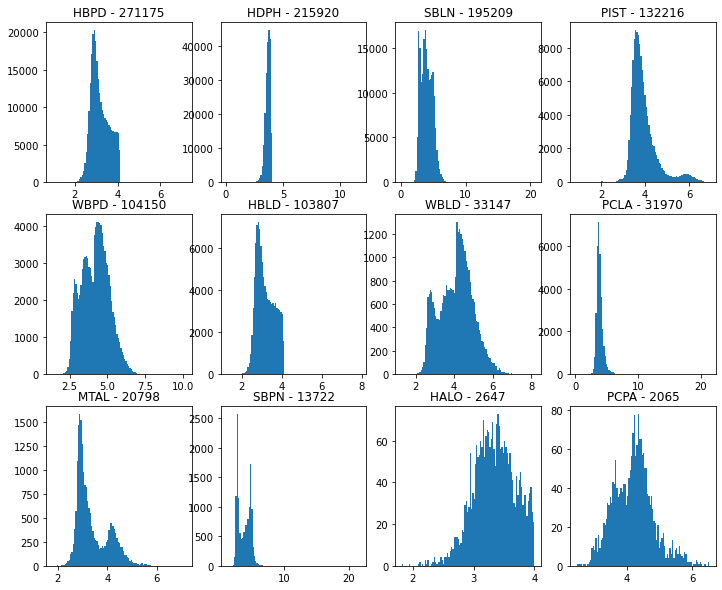

In [79]:
dists = {}
for int_dists, int_types, _, _, _ in train_d.values():
    for (i, j), inttype_label in int_types.items():
        inttype = inttype_list[inttype_label]
        dist = int_dists[(i, j)]
        if not inttype in dists:
            dists[inttype] = []
        dists[inttype].append(dist)
dists = [(inttype, l) for inttype, l in dists.items()]
dists.sort(key=lambda p:-len(p[1]))
plt.figure(figsize=(12,10))
for i, (inttype, l) in enumerate(dists, start=1):
    plt.subplot(3, 4, i)
    plt.title(f'{inttype} - {len(l)}')
    plt.hist(l, 100)
plt.show()

with open('derived_dataset_ver2/inttype_train_frequency.txt', 'w') as writer:
    writer.write('0: DIST - None\n')
    writer.write('1: NOIT - None\n')
    for i, (inttype, l) in enumerate(dists, start=2):
        writer.write(f'{i}: {inttype} - {len(l)}\n')

In [80]:
train_inttype_occ = [0 for _ in inttype_list]
for (fasta, smiles), (int_dists, int_types, _, _, _) in train_d.items():
    for inttype in set(int_types.values()):
        train_inttype_occ[inttype] += 1
with open('derived_dataset_ver2/inttype_train_occurrence.txt', 'w') as writer:
    writer.write(f'0: DIST - {None}\n')
    writer.write(f'1: NOIT - {None}\n')
    for i, inttype in enumerate(inttype_list[2:], start=2):
        writer.write('{}: {} - {}\n'.format(i, inttype, train_inttype_occ[i]))
    

In [81]:
dev_inttype_occ = [0 for _ in inttype_list]
for (fasta, smiles), (int_dists, int_types, _, _, _) in dev_d.items():
    for inttype in set(int_types.values()):
        dev_inttype_occ[inttype] += 1
with open('derived_dataset_ver2/inttype_dev_occurrence.txt', 'w') as writer:
    writer.write(f'0: DIST - {None}\n')
    writer.write(f'1: NOIT - {None}\n')
    for i, inttype in enumerate(inttype_list[2:], start=2):
        writer.write('{}: {} - {}\n'.format(i, inttype, dev_inttype_occ[i]))

In [82]:
test_inttype_occ = [0 for _ in inttype_list]
for (fasta, smiles), (int_dists, int_types, _, _, _) in test_d.items():
    for inttype in set(int_types.values()):
        test_inttype_occ[inttype] += 1
with open('derived_dataset_ver2/inttype_test_occurrence.txt', 'w') as writer:
    writer.write(f'0: DIST - {None}\n')
    writer.write(f'1: NOIT - {None}\n')
    for i, inttype in enumerate(inttype_list[2:], start=2):
        writer.write('{}: {} - {}\n'.format(i, inttype, test_inttype_occ[i]))

In [83]:
inttype_list

['DIST',
 'NOIT',
 'HBPD',
 'HDPH',
 'SBLN',
 'PIST',
 'WBPD',
 'HBLD',
 'WBLD',
 'PCLA',
 'MTAL',
 'SBPN',
 'HALO',
 'PCPA']

In [85]:
for _, _, chainstr, _, res_mask in train_d.values():
    if chainstr.startswith('5exz:A'):
        print(res_mask)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T